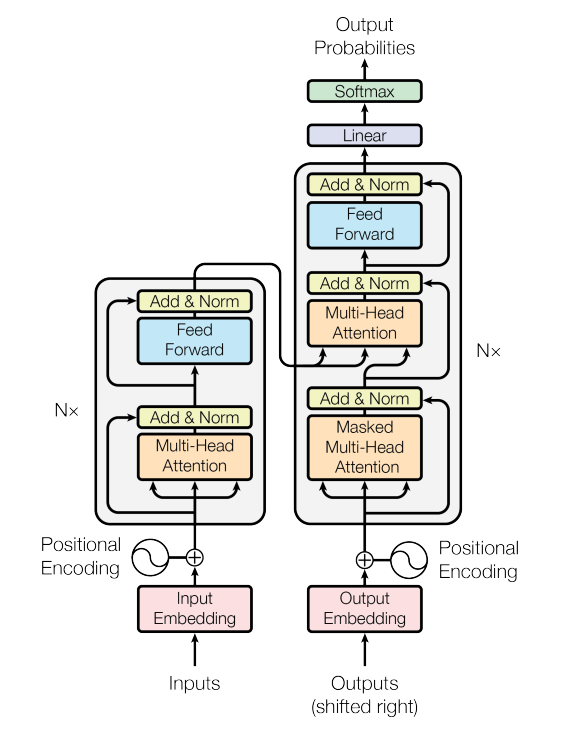

전체 로드맵 (논문 → 코드 1:1 대응)

Transformer 논문 구조를 그대로 클래스 단위로 쪼갭니다.
```mathematica
Input
 └─ Embedding
 └─ Positional Encoding
 └─ Encoder Block × N
     ├─ Multi-Head Self Attention
     ├─ Add & Norm
     ├─ Feed Forward
     └─ Add & Norm
 └─ (Decoder도 동일 구조 + Mask)
```

## 1. 입력 텐서 모양(전제)

- `input_ids`: `(B, T)` (배치, 시퀀스 길이)
- `d_model`: 모델 차원
- `V`: vocab size

## 2. Token Embedding (논문에서의 의미)

논문은 “입력 토큰을 d_model 차원으로 매핑한 임베딩”을 쓰고, **Positional Encoding을 더합니다**.

가장 기본은:
$$
\text{Embedding}(input\_ids) \in \mathbb{R}^{B \times T \times d_{model}}
$$

### (중요) 논문 구현 관례: $\sqrt{d_{model}}$ 스케일링

논문(Attention is All You Need)에서 임베딩은 보통 이렇게 스케일링합니다:

$$
x = \sqrt{d_{model}} \cdot \text{Embedding}(input\_ids)
$$

이유(핵심만):

- PE를 더할 때, 임베딩과 PE의 크기 스케일을 맞춰서 학습 안정화

## 3. “입력 임베딩 레이어”를 OOP로 분리

토큰 임베딩 + (선택) 드롭아웃까지 포함해서 클래스로 만듭니다.

In [1]:
import torch
import torch.nn as nn
import math

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embed = nn.Embedding(vocab_size, d_model)

    def forward(self, input_ids):
        """
        input_ids: (B, T) long
        return: (B, T, d_model)
        """
        x = self.embed(input_ids)
        return x * math.sqrt(self.d_model)

nn.Embedding은 **lookup table (조회 테이블)**입니다.
```py
embed = nn.Embedding(vocab_size=5, d_model=3)

# 내부적으로 이런 테이블 생성 (랜덤 초기화)
# embedding_table: (vocab_size, d_model)
tensor([[0.2, -0.5, 0.8],   # token_id=0의 벡터
        [0.1,  0.3, -0.2],  # token_id=1의 벡터
        [-0.4, 0.7,  0.1],  # token_id=2의 벡터
        [0.6, -0.1,  0.4],  # token_id=3의 벡터
        [0.3,  0.2, -0.6]]) # token_id=4의 벡터
```
<br>
내부 구현

```py
class MyEmbedding:
    def __init__(self, vocab_size, d_model):
        # 학습 가능한 weight 테이블
        self.weight = nn.Parameter(
            torch.randn(vocab_size, d_model)
        )
    
    def forward(self, input_ids):
        # 단순히 인덱싱!
        return self.weight[input_ids]

# 실제 사용
embed = MyEmbedding(10000, 512)
input_ids = torch.tensor([15, 234])
output = embed.weight[input_ids]  # (2, 512)
```

## 4. 왜 Positional Encoding이 필요한가 (한 줄)

Transformer의 Self-Attention은 순서 정보를 전혀 쓰지 않습니다.
그래서 “토큰 위치”를 벡터로 만들어서 임베딩에 더해줘야 합니다.

## 5. 논문 Positional Encoding 수식

논문에 나온 정의는 이겁니다:

$$
PE(pos, 2i) = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
$$

$$
PE(pos, 2i+1) = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
$$


- `pos` : 시퀀스 내 위치 (0, 1, 2, …)
- `i` : 임베딩 차원 인덱스
- `d_model` : 임베딩 전체 차원

짝수 차원 → `sin`

홀수 차원 → `cos`

## 6. 이 수식의 구조를 해체해보면

### (1) 주파수가 차원마다 다름

$$
\frac{1}{10000^{2i/d_{model}}}
$$

- 작은 차원(i 작음) → **주파수 큼** → 빠르게 변함
- 큰 차원(i 큼) → **주파수 작음** → 천천히 변함

→ 하나의 위치를 **여러 해상도의 사인파**로 표현


### (2) sin / cos를 쌍으로 쓰는 이유

- 같은 주파수에서 `sin`, `cos`는 **위상 차이 90°**
- 그래서 두 벡터의 내적으로
    - “거리 정보”가 선형 조합으로 표현 가능

논문에서 말하는 핵심 문장:

> relative position을 linear하게 추론 가능

<br>

`선형 변환 가능 (가장 중요!)`
```py
# sin/cos 덧셈 정리
sin(a + b) = sin(a)cos(b) + cos(a)sin(b)
cos(a + b) = cos(a)cos(b) - sin(a)sin(b)

# 행렬 형태로
                 ┌───────────────┐
[sin(pos + k)]   [cos(k)   sin(k)] [sin(pos)]   [sin(pos)cos(k) + cos(pos)sin(k)]
               =                              = 
[cos(pos + k)]   [-sin(k)  cos(k)] [cos(pos)]   [cos(pos)cos(k) - sin(pos)sin(k)]
                 └───────────────┘
                    회전 행렬!
```
의미: "k칸 떨어진 위치 = 회전 행렬로 표현"

## 7. 중요한 성질 (논문이 이걸 선택한 이유)

이 PE는 학습 파라미터가 아니라 **결정적(deterministic)** 입니다.

그래서:

- 훈련 시 보지 못한 **더 긴 시퀀스**에도 일반화 가능
- `pos + k` 관계가 벡터 공간에서 유지됨

## 8. Positional Encoding 토치 구현 (논문 그대로, 객체지향)

In [2]:
import torch
import torch.nn as nn
import math

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)

        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) # (max_len, 1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
         ) # 1 / {10000 ^ {2i / d_model}}
        
        # div_term의 shape=(d_model//2,) => * 연산 시 (max_len, d_model//2) 로 broadcasting 됨.
        pe[:, 0::2] = torch.sin(position * div_term) # 짝수
        pe[:, 1::2] = torch.cos(position * div_term) # 홀수

        pe = pe.unsqueeze(0) # (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """"
        x: (batch, seq_len, d_model)
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len] # (batch, seq_len, d_model)

In [4]:
torch.arange(0, 6, dtype=torch.float).unsqueeze(1).shape,  torch.arange(0, 4, 2).shape, \
    (torch.arange(0, 6, dtype=torch.float).unsqueeze(1) * torch.arange(0, 4, 2)).shape

(torch.Size([6, 1]), torch.Size([2]), torch.Size([6, 2]))

## 9. (옵션) Padding mask 만들기: “어텐션에서 패딩 무시”용

보통 pad_id=0 같은 걸 쓰고, 패딩 토큰은 attention score에서 제외해야 합니다.

형태 정리

Self-attention score는 보통 `(B, H, T, T)` 형태로 가니까, mask도 broadcast되게 만듭니다.

key 쪽(마지막 T)을 가리는 mask가 필요

simplest: `(B, 1, 1, T)` (head, query축으로 broadcast)

In [5]:
def make_padding_mask(input_ids, pad_id=0):
    """
    input_ids: (B, T)
    return mask: (B, 1, 1, T) where 1 means keep, 0 means mask-out
    """
    mask = (input_ids != pad_id).unsqueeze(1).unsqueeze(2)
    return mask

In [6]:
input_ids = torch.tensor([15, 132])
make_padding_mask(input_ids)

tensor([[[True]],

        [[True]]])

이 mask를 `ScaledDotProductAttention`에서:

```py
scores = scores.masked_fill(mask == 0, -1e9)
```

로 쓰는 구조입니다.

## 10. 이제 “Embedding + PositionalEncoding”을 합친 입력 모듈

논문에서 실제로 encoder/decoder에 들어가는 입력은:

$$

x_0 = \sqrt{d_{model}}E + PE

$$

그래서 입력 스택을 한 모듈로 묶으면 깔끔합니다.

In [7]:
class InputEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model, max_len=5000, dropout=0.1):
        super().__init__()
        self.token = TokenEmbedding(vocab_size, d_model)
        self.pos = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, input_ids):
        x = self.token(input_ids) # (batch_size, seq_len, d_model)
        x = self.pos(x)           # + PE
        x = self.dropout(x)
        return x

## 1️⃣ Scaled Dot-Product Attention (논문 수식부터)

논문 핵심 수식:
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

### 수식 해석 (중요)

- $Q \in \mathbb{R}^{T \times d_k}$
- $K \in \mathbb{R}^{T \times d_k}$
- $V \in \mathbb{R}^{T \times d_v}$
- $QK^T \rightarrow (T \times T)$ → “모든 토큰 간 유사도”
- $\sqrt{d_k}$ → 분산 폭주 방지 (논문에서 핵심)

## 2️⃣ ScaledDotProductAttention 클래스 (밑바닥 구현)

In [8]:
import torch
import torch.nn as nn
import math

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, Q, K, V, mask=None):
        """
        Q, K, V: (batch, head, seq_len, d_k)
        """
        scores = torch.matmul(Q, K.transpose(-2, -1)) # QK^T
        scores = scores / math.sqrt(Q.size(-1)) # / sqrt(d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9) # True인 위치를 -1e9로 채움

        attn = torch.softmax(scores, dim=-1) # (batch, head, seq_len, seq_len), softmax는 정규화, reduce 아님
        out = torch.matmul(attn, V) # (batch, head, seq_len, d_k)
        return out, attn

```py
mask = torch.tensor([[1, 0, 1],
                     [0, 1, 0]])

# 비교 연산 → Boolean 텐서 생성
mask == 0
# tensor([[False,  True, False],
#         [ True, False,  True]])

scores.masked_fill(mask == 0, -1e9)
# mask가 0인 곳을 -1e9로 채움
```

## 3️⃣ Multi-Head Attention (논문 정의)

논문 수식:

$$
\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
$$

$$\text{MultiHead}(Q,K,V)
= \text{Concat}(\text{head}_1,\dots,\text{head}_h)W^O
$$

### 핵심 포인트

- $W^Q, W^K, W^V \in \mathbb{R}^{d_{\text{model}} \times d_{\text{model}}}$ 
- head별 projection을 **하나의 큰 행렬로 처리**
- reshape & transpose로 head 분리

## 4️⃣ MultiHeadAttention 클래스 (진짜 중요)

In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0 # 조건이 거짓이면 프로그램을 멈추는 디버깅 도구

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # W_Q, W_K, W_V는 head별이 아니라 전체 projection
        self.W_Q = nn.Linear(d_model, d_model)
        self.W_K = nn.Linear(d_model, d_model)
        self.W_V = nn.Linear(d_model, d_model)

        self.attention = ScaledDotProductAttention()
        self.W_O = nn.Linear(d_model, d_model)

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0) # (batch_size, seq_len, d_model)

        # 1. Linear projection
        Q = self.W_Q(Q) # (batch, seq_len, d_model)
        K = self.W_K(K)
        V = self.W_V(V)

        # 2. Split heads
        Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2) # -1은 seq_len
        K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # 3. Attention
        out, attn = self.attention(Q, K, V, mask) # (batch_size, seq_len, num_heads, d_k)

        # 4. Concat heads
        out = out.transpose(1, 2).contiguous() # .contiguous(): 메모리 레이아웃을 연속적으로 재배치
        out = out.view(batch_size, -1, self.d_model) # reshape은 내부적으로 필요시 contiguous 호출
        # view(): contiguous 텐서만 받음
        
        # 5. Final linear
        out = self.W_O(out) # (batch_size, seq_len, d_model)
        return out

## 5️⃣ Position-wise Feed Forward Network

논문 수식:
$$
\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2
$$

- 모든 시점에 독립적으로 적용
- kernel_size=1인 Conv1D는 각 위치를 독립적으로 처리하므로, position-wise Linear와 수학적으로 완전히 동일
- x → [확장] → ReLU → [축소]
- 입출력 차원은 같지만, 중간에 넓은 공간에서 비선형 변환을 거쳐 토큰의 표현을 풍부하게 만듦

In [10]:
class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1): # d_model=512, d_ff=2048, 경험적으로 4배 확장이 성능/효율 균형이 좋음
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        return self.fc2(self.dropout(torch.relu(self.fc1(x))))

## 6️⃣ Add & Norm (Residual + LayerNorm)

In [11]:
class AddNorm(nn.Module):
    def __init__(self, d_model, dropout=0.1):
        super().__init__()
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer_out):
        return self.norm(x + self.dropout(sublayer_out))

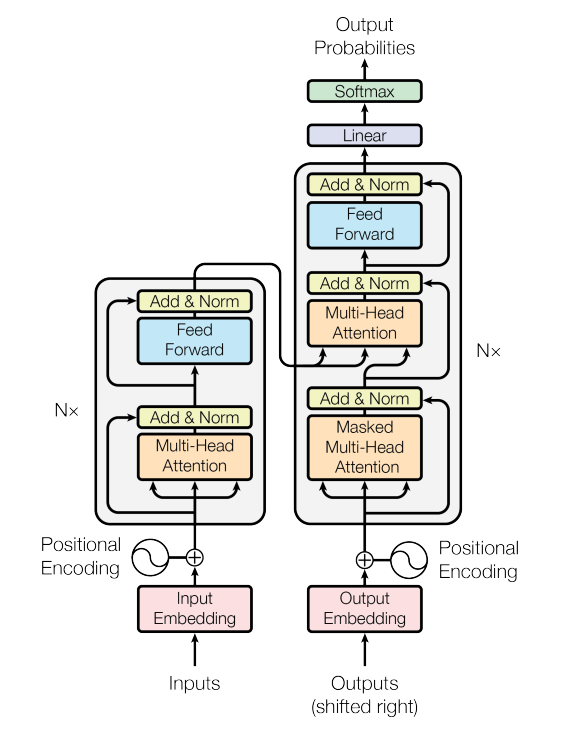

## 7️⃣ Encoder Block (논문 한 블록)

In [12]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, num_heads)
        self.addnorm1 = AddNorm(d_model, dropout)

        self.ffn = FeedForward(d_model, d_ff, dropout)
        self.addnorm2 = AddNorm(d_model, dropout)

    def forward(self, x, src_mask=None):
        attn_out = self.attn(x, x, x, src_mask)
        x = self.addnorm1(x, attn_out)

        ffn_out = self.ffn(x)
        x = self.addnorm2(x, ffn_out)
        return x

## 8️⃣ Encoder 전체

In [13]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderBlock(d_model, num_heads, d_ff, dropout) \
            for _ in range(num_layers)
        ])

    def forward(self, x, src_mask=None):
        for layer in self.layers:
            x = layer(x, src_mask)
        return x

In [14]:
encoder = Encoder(3, 16, 4, 64)

In [15]:
encoder

Encoder(
  (layers): ModuleList(
    (0-2): 3 x EncoderBlock(
      (attn): MultiHeadAttention(
        (W_Q): Linear(in_features=16, out_features=16, bias=True)
        (W_K): Linear(in_features=16, out_features=16, bias=True)
        (W_V): Linear(in_features=16, out_features=16, bias=True)
        (attention): ScaledDotProductAttention()
        (W_O): Linear(in_features=16, out_features=16, bias=True)
      )
      (addnorm1): AddNorm(
        (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ffn): FeedForward(
        (fc1): Linear(in_features=16, out_features=64, bias=True)
        (fc2): Linear(in_features=64, out_features=16, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (addnorm2): AddNorm(
        (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
)

## 0) Decoder에서 필요한 마스크 2개

### A. Padding mask (패딩 토큰 무시)

- src 패딩 마스크: `(B, 1, 1, S)` → cross-attn에서 **K/V(src)** 쪽을 가림
- tgt 패딩 마스크: `(B, 1, 1, T)` → self-attn에서 **K/V(tgt)** 쪽을 가림

### B. Causal mask (미래 토큰 못 보게)

- `(1, 1, T, T)` (브로드캐스트)
- 아래 삼각형(현재 포함)만 1, 미래는 0

### Self-attn용 최종 마스크

self-attn의 score shape은 `(B, H, T, T)` 이므로, mask는 브로드캐스트되게 `(B, 1, T, T)`로 만들면 깔끔합니다.

1) 마스크 생성 함수들

In [16]:
import torch

def make_padding_mask(input_ids, pad_id=0):
    """
    input_ids: (B, L)
    return: (B, 1, 1, L)  where 1=keep, 0=mask
    """
    return (input_ids != pad_id).unsqueeze(1).unsqueeze(2)

def make_causal_mask(seq_len, device=None):
    """
    return: (1, 1, T, T) where 1=keep (allowed), 0=mask (future)
    """
    # lower-triangular including diagonal
    mask = torch.tril(torch.ones(seq_len, seq_len, dtype=torch.bool, device=device))
    return mask.unsqueeze(0).unsqueeze(0)  # (1,1,T,T)

def make_tgt_self_attn_mask(tgt_ids, pad_id=0):
    """
    tgt_ids: (B, T)
    return: (B, 1, T, T)  where 1=keep, 0=mask
    """
    B, T = tgt_ids.shape
    pad_mask = make_padding_mask(tgt_ids, pad_id=pad_id)         # (B,1,1,T)
    causal_mask = make_causal_mask(T, device=tgt_ids.device)      # (1,1,T,T)

    # pad_mask broadcasts over query length -> (B,1,T,T) after &
    mask = pad_mask & causal_mask
    # pad_mask: (B,1,1,T) will broadcast to (B,1,T,T)
    return mask

## 2) DecoderBlock (논문 그림 그대로)

Decoder 블록은 3단계입니다.

1. **Masked Multi-Head Self-Attention** (tgt가 자기 자신을 보되 미래는 못 봄)
2. **Encoder-Decoder Attention** (Q는 tgt, K/V는 src 출력)
3. **FFN**

In [17]:
import torch.nn as nn

class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        # 1) masked self-attn
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.addnorm1 = AddNorm(d_model, dropout)

        # 2) cross-attn(encoder-decoder attn)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.addnorm2 = AddNorm(d_model, dropout)

        # 3) FFN
        self.ffn = FeedForward(d_model, d_ff)
        self.addnorm3 = AddNorm(d_model, dropout)

    def forward(self, x, enc_out, tgt_mask=None, src_mask=None):
        """
        x:       (B, T, d_model)  decoder input (tgt embedding + PE)
        enc_out: (B, S, d_model)  encoder output
        tgt_mask: (B, 1, T, T)    for masked self-attn
        src_mask: (B, 1, 1, S)    for cross-attn (mask src padding on K/V)
        """
        # (1) masked self-attn: Q=K=V=x
        self_attn_out = self.self_attn(x, x, x, mask=tgt_mask)
        x = self.addnorm1(x, self_attn_out)

        # (2) cross-attn: Q=x, K=V=enc_out
        cross_attn_out = self.cross_attn(x, enc_out, enc_out, mask=src_mask)
        x = self.addnorm2(x, cross_attn_out)

        # (3) FFN
        ffn_out = self.ffn(x)
        x = self.addnorm3(x, ffn_out)
        return x

## 3) Decoder 전체 (블록 N개)

In [18]:
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            DecoderBlock(d_model, num_heads, d_ff, dropout) \
            for _ in range(num_layers)
        ])

    def forward(self, x, enc_out, tgt_mask=None, src_mask=None):
        for layer in self.layers:
            x = layer(x, enc_out, tgt_mask=tgt_mask, src_mask=src_mask)
        return x

## 4) 마스크 shape이 헷갈릴 때 체크포인트

- self-attn scores: (B,H,T,T)
⇒ mask는 (B,1,T,T)면 안전 (head로 브로드캐스트)

- cross-attn scores: (B,H,T,S)
⇒ src padding mask (B,1,1,S)면 안전 (head, query로 브로드캐스트)

# Transformer (Encoder-Decoder)

In [19]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size,
                 d_model=256, num_heads=8, d_ff=1024,
                 num_layers=4, dropout=0.1, pad_id=0,
                 max_len=5000, tie_weights=False):
        super().__init__()
        self.pad_id = pad_id

        self.src_embed = InputEmbedding(src_vocab_size, d_model, max_len=max_len, dropout=dropout)
        self.tgt_embed = InputEmbedding(tgt_vocab_size, d_model, max_len=max_len, dropout=dropout)

        self.encoder = Encoder(num_layers, d_model, num_heads, d_ff, dropout)
        self.decoder = Decoder(num_layers, d_model, num_heads, d_ff, dropout)

        self.out_proj = nn.Linear(d_model, tgt_vocab_size, bias=False)

        # (옵션) weight tying: output projection weight = target embedding weight
        if tie_weights:
            self.out_proj.weight = self.tgt_embed.token.embed.weight

    def forward(self, src_ids, tgt_ids_in):
        """
        src_ids:    (B, S)
        tgt_ids_in: (B, T)  (teacher forcing 입력: <bos> y1 y2 ...)
        return logits: (B, T, Vtgt)
        """
        src_mask = make_padding_mask(src_ids, pad_id=self.pad_id)          # (B,1,1,S)
        tgt_mask = make_tgt_self_attn_mask(tgt_ids_in, pad_id=self.pad_id) # (B,1,T,T)

        enc_in = self.src_embed(src_ids)          # (B,S,d_model)
        enc_out = self.encoder(enc_in, src_mask=src_mask)

        dec_in = self.tgt_embed(tgt_ids_in)       # (B,T,d_model)
        dec_out = self.decoder(dec_in, enc_out, tgt_mask=tgt_mask, src_mask=src_mask)

        logits = self.out_proj(dec_out)           # (B,T,Vtgt)
        return logits

    @torch.no_grad()
    def greedy_decode(self, src_ids, bos_id, eos_id, max_len=50):
        """
        src_ids: (B,S)  (B는 보통 1로 쓰는 게 편함)
        return: generated ids (B, <=max_len)
        """
        self.eval()

        src_mask = make_padding_mask(src_ids, pad_id=self.pad_id)
        enc_out = self.encoder(self.src_embed(src_ids), src_mask=src_mask)

        B = src_ids.size(0)
        ys = torch.full((B, 1), bos_id, dtype=torch.long, device=src_ids.device)  # (B,1)

        for _ in range(max_len - 1):
            tgt_mask = make_tgt_self_attn_mask(ys, pad_id=self.pad_id)  # (B,1,T,T)
            dec_out = self.decoder(self.tgt_embed(ys), enc_out, tgt_mask=tgt_mask, src_mask=src_mask)
            logits = self.out_proj(dec_out)  # (B,T,V)
            next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)  # (B,1)
            ys = torch.cat([ys, next_token], dim=1)

            if (next_token == eos_id).all():
                break

        return ys

## Toy Dataset: Copy task

In [20]:
from torch.utils.data import Dataset, DataLoader
class CopyDataset(Dataset):
    """
    src:  <bos> x1 x2 ... xN <eos> (pad)
    tgt:  <bos> x1 x2 ... xN <eos> (pad)
    """
    def __init__(self, num_samples, min_len, max_len, vocab_size, pad_id=0, bos_id=1, eos_id=2):
        super().__init__()
        self.num_samples = num_samples
        self.min_len = min_len
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.pad_id = pad_id
        self.bos_id = bos_id
        self.eos_id = eos_id

        assert vocab_size > 10
        # 실제 토큰은 [3..vocab_size-1] 사용
        self.min_tok = 3

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        L = torch.randint(self.min_len, self.max_len + 1, (1,)).item()
        seq = torch.randint(self.min_tok, self.vocab_size, (L,))

        src = torch.cat([torch.tensor([self.bos_id]), seq, torch.tensor([self.eos_id])], dim=0)
        tgt = torch.cat([torch.tensor([self.bos_id]), seq, torch.tensor([self.eos_id])], dim=0)

        return src, tgt


def collate_pad(batch, pad_id=0):
    srcs, tgts = zip(*batch)
    src_lens = [len(s) for s in srcs]
    tgt_lens = [len(t) for t in tgts]
    S = max(src_lens)
    T = max(tgt_lens)

    src_pad = torch.full((len(batch), S), pad_id, dtype=torch.long)
    tgt_pad = torch.full((len(batch), T), pad_id, dtype=torch.long)

    for i, (s, t) in enumerate(zip(srcs, tgts)):
        src_pad[i, :len(s)] = s
        tgt_pad[i, :len(t)] = t

    return src_pad, tgt_pad


## Train loop (teacher forcing)

In [21]:
def train_one_epoch(model, loader, optimizer, pad_id=0, device="cpu"):
    model.train()
    loss_fn = nn.CrossEntropyLoss(ignore_index=pad_id)

    total_loss = 0.0
    total_tokens = 0
    acc_sum = 0.0
    tok_sum = 0

    for src_ids, tgt_ids in loader:
        src_ids = src_ids.to(device)
        tgt_ids = tgt_ids.to(device)

        # teacher forcing:
        # input  = tgt[:, :-1]  (<bos> y1 y2 ...)
        # label  = tgt[:, 1:]   (y1 y2 ... <eos>)
        tgt_in = tgt_ids[:, :-1]
        tgt_y  = tgt_ids[:, 1:]

        logits = model(src_ids, tgt_in)  # (B, T-1, V)
        B, Tm1, V = logits.shape

        loss = loss_fn(logits.reshape(B * Tm1, V), tgt_y.reshape(B * Tm1))

        optimizer.zero_grad()
        loss.backward()

        # (옵션) grad clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # token 수(패딩 제외)로 평균 내기
        with torch.no_grad():
            pred = logits.argmax(dim=-1)      # (B, T-1)
            mask = (tgt_y != pad_id)          # (B, T-1)
            correct = (pred[mask] == tgt_y[mask]).sum().item()
            total = mask.sum().item()
            
            nonpad = mask.sum().item()

        total_loss += loss.item() * nonpad
        total_tokens += nonpad
        acc_sum += correct
        tok_sum += total

    epoch_acc = acc_sum / max(tok_sum, 1)
    return total_loss / max(total_tokens, 1), epoch_acc

## Run (sanity check)

In [22]:
import torch.optim as optim
def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"

    pad_id = 0
    bos_id = 1
    eos_id = 2

    vocab_size = 100  # src/tgt 동일 vocab로 가정 (toy)
    d_model = 128
    num_heads = 8
    d_ff = 512
    num_layers = 2
    dropout = 0

    EPOCHS=30
    LR = 1e-3

    model = Transformer(
        src_vocab_size=vocab_size,
        tgt_vocab_size=vocab_size,
        d_model=d_model,
        num_heads=num_heads,
        d_ff=d_ff,
        num_layers=num_layers,
        dropout=dropout,
        pad_id=pad_id,
        tie_weights=True,   # 논문에서 자주 쓰는 tying
    ).to(device)

    ds = CopyDataset(
        num_samples=5000,
        min_len=3,
        max_len=12,
        vocab_size=vocab_size,
        pad_id=pad_id,
        bos_id=bos_id,
        eos_id=eos_id,
    )
    loader = DataLoader(ds, batch_size=64, shuffle=True, collate_fn=lambda b: collate_pad(b, pad_id=pad_id))

    optimizer = optim.Adam(model.parameters(), lr=LR)

    for epoch in range(1, EPOCHS):
        avg_loss, acc = train_one_epoch(model, loader, optimizer, pad_id=pad_id, device=device)
        print(f"epoch {epoch} | loss/token: {avg_loss:.4f} | acc: {acc:.4f}")

        # 간단 디코딩 확인 (배치 1개)
        src_ids, tgt_ids = ds[0]
        src_ids = src_ids.unsqueeze(0).to(device)  # (1,S)
        pred = model.greedy_decode(src_ids, bos_id=bos_id, eos_id=eos_id, max_len=30)

        print("src :", src_ids.squeeze(0).tolist())
        print("pred:", pred.squeeze(0).tolist())
        print("---")


if __name__ == "__main__":
    main()

epoch 1 | loss/token: 10.5606 | acc: 0.0887
src : [1, 94, 7, 52, 2]
pred: [1, 2]
---
epoch 2 | loss/token: 3.7740 | acc: 0.1310
src : [1, 57, 60, 79, 22, 59, 56, 70, 36, 47, 29, 35, 34, 2]
pred: [1, 79, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47]
---
epoch 3 | loss/token: 2.9008 | acc: 0.1718
src : [1, 19, 23, 24, 45, 2]
pred: [1, 45, 45, 45, 45, 2]
---
epoch 4 | loss/token: 2.6599 | acc: 0.1999
src : [1, 77, 70, 63, 31, 2]
pred: [1, 63, 63, 63, 63, 63, 2]
---
epoch 5 | loss/token: 2.5826 | acc: 0.2054
src : [1, 96, 40, 6, 44, 11, 50, 26, 45, 2]
pred: [1, 44, 44, 44, 44, 6, 6, 6, 6, 2]
---
epoch 6 | loss/token: 2.5170 | acc: 0.2157
src : [1, 37, 77, 97, 2]
pred: [1, 77, 77, 77, 2]
---
epoch 7 | loss/token: 2.3805 | acc: 0.2407
src : [1, 11, 14, 43, 36, 79, 10, 26, 56, 84, 96, 51, 27, 2]
pred: [1, 43, 43, 43, 43, 43, 43, 43, 10, 10, 10, 10, 2]
---
epoch 8 | loss/token: 2.2346 | acc: 0.2717
src : [1, 48, 69, 13, 12, 71, 